This notebook is about reshaping a bit Alex's work (4_mnist_classifier notebook) to use the 1d-maxpooling after reindexing and also to use Chebishev coefficients for the filtering. 

In [1]:
%cd ..

/home/clement/Dropbox/MVA/Graphs in ML/project/graphConvNet


In [2]:
# Imports
import sys, os
sys.path.insert(0,os.getcwd())  # add current folder to sources
import numpy
import tensorflow as tf
import matplotlib.pyplot as plt

from src.mnist import load_mnist  # helper to load MNIST data
from src.GraphMaxPooling import GraphMaxPooling
from src.GraphLayers import *

%matplotlib inline

# Data, coarsening, laplacians

In [3]:
# Load mnist dataset
training_mnist = load_mnist(dataset='training')
testing_mnist = load_mnist(dataset='testing')

training_data = numpy.reshape(training_mnist[0], [training_mnist[0].shape[0],28*28])
training_data = training_data/255.0
training_labels = training_mnist[1]
training_cats = numpy.zeros([training_labels.shape[0], 10])
for i in range(0,training_labels.shape[0]):
    training_cats[i][training_labels[i]]=1
    
testing_data = numpy.reshape(testing_mnist[0], [testing_mnist[0].shape[0],28*28])
testing_data = testing_data/255.0
testing_labels = testing_mnist[1]
testing_cats = numpy.zeros([testing_labels.shape[0], 10])
for i in range(0,testing_labels.shape[0]):
    testing_cats[i][testing_labels[i]]=1

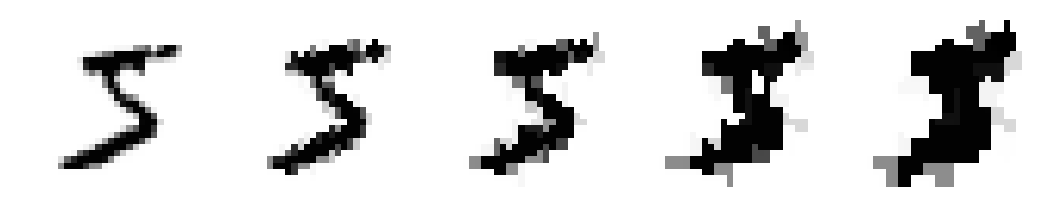

In [4]:
# use the GraphMaxPooling class to build a grid and perform the coarsening
W = GraphMaxPooling.generate_grid(*training_mnist[0][0].shape)
foo_pooling = GraphMaxPooling(W, 4)
foo_pooling.plot_pooled_images(training_mnist[0][0].reshape((-1,)))  # plot what happens

In [5]:
# now we retrieve all the new ordering and we add the virtuals nodes and reshape the signal
# to clean matrices X_train and X_test

ordering = foo_pooling.new_order
init_dim = 28*28  # initial dimension of the images
n_virtuals = len(ordering) - init_dim  # number of virtual nodes to add

# First for X_train
X_train = training_mnist[0].reshape((-1, init_dim))  # flatten images
X_train = np.hstack((X_train, np.zeros((X_train.shape[0], n_virtuals))))  # add zeros for virtuals
X_train = X_train[:, ordering]  # reorder

# Then for X_test
X_test = testing_mnist[0].reshape((-1, init_dim))  # flatten images
X_test = np.hstack((X_test, np.zeros((X_test.shape[0], n_virtuals))))  # add zeros for virtuals
X_test = X_test[:, ordering]  # reorder

In [6]:
print("X_train: {}, including {} true nodes and {} virtual nodes".format(X_train.shape, init_dim, n_virtuals))
print("X_test:  {}, including {} true nodes and {} virtual nodes".format(X_test.shape, init_dim, n_virtuals))

X_train: (60000, 1056), including 784 true nodes and 272 virtual nodes
X_test:  (10000, 1056), including 784 true nodes and 272 virtual nodes


In [7]:
# Now we retrieve all the Laplacians
laplacians = foo_pooling.get_laplacians(how='unn')
laplacians = [np.array(L, dtype=np.float32) for L in laplacians]  # cast to float32
print([L.shape for L in laplacians])

[(1056, 1056), (528, 528), (264, 264), (132, 132), (66, 66)]


And that's all we need. Now we will (in the next section) build our network, as if we were dealing with 1d signals (for the max-pooling part). The only tricky part is to implement the filters using Chebyshev. 

# Building the network

To build our CNN we use the objects from the GraphLayers module. The GraphConv objects take as input a symbolic tensor which must be the output attribute from the previous layer.

In [8]:
# We instantiate Session object
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [9]:
X_input = tf.placeholder(tf.float32, [None, laplacians[0].shape[0]])  # X_train or X_test
X_input_ = tf.expand_dims(X_input, 2)  # add depth dimension

GConv1 = GraphConv(X_input_, K=5, F=10, L=laplacians[0])

GConv1.max_pool()

GConv2 = GraphConv(GConv1.output, K=5, F=2, L=laplacians[1])  # 2 filters on the 10 previous filters = depth 20

GConv2.max_pool()

GConv3 = GraphConv(GConv2.output, K=5, F=2, L=laplacians[2])  # 2 filters on the 20 previous filters = depth 40

GConv3.max_pool()

#GConv4 = GraphConv(GConv3.output, K=5, F=2, L=laplacians[3])  # 2 filters on the 40 previous filters = depth 80

#GConv4.max_pool()

dense1 = Dense(GConv3.output, u=256)
dense1.relu()

dense2 = Dense(dense1.output, u=10)
dense2.sofmax()

ygcnn = dense2.output

# placeholder for the labels
y = tf.placeholder(tf.float32, shape=[None, 10])

# Training phase

Train phase (copied from 4_mnist_classifier.ipynb)

In [10]:
# Define Loss
cross_entropy = tf.reduce_mean(
    -tf.reduce_sum(y * tf.log(ygcnn), reduction_indices=[1]))
weights = tf.trainable_variables()
weights_decay = tf.add_n([tf.nn.l2_loss(v) for v in weights])*0.001
loss = tf.add(cross_entropy, weights_decay)
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)
correct_prediction = tf.equal(tf.argmax(ygcnn,1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [11]:
# We initialize the values
sess.run(tf.global_variables_initializer())

In [12]:
# Train
for i in range(1000):
    idx = numpy.random.permutation(training_data.shape[0])
    idx = idx[0:100]
    if i % 100 == 0:
        train_accuracy = accuracy.eval(feed_dict={X_input:X_train[idx], y: training_cats[idx]})
        idx = numpy.random.permutation(testing_data.shape[0])
        idx = idx[0:100]
        test_accuracy = accuracy.eval(feed_dict={X_input: X_test[idx], y:testing_cats[idx]})
        print("step %d, training accuracy %g, testing accuracy %g"%(i, train_accuracy, test_accuracy))
    train_step.run(feed_dict={X_input: X_train[idx], y: training_cats[idx]})

step 0, training accuracy 0.09, testing accuracy 0.12
step 100, training accuracy 0.71, testing accuracy 0.83
step 200, training accuracy 0.79, testing accuracy 0.85
step 300, training accuracy 0.89, testing accuracy 0.86
step 400, training accuracy 0.89, testing accuracy 0.92
step 500, training accuracy 0.94, testing accuracy 0.87
step 600, training accuracy 0.9, testing accuracy 0.95
step 700, training accuracy 0.95, testing accuracy 0.92
step 800, training accuracy 0.91, testing accuracy 0.93
step 900, training accuracy 0.94, testing accuracy 0.9
